# Homework 5 Question 3: Hovercraft rendezvous. 
Alice and Bob are cruising on Lake Mendota in their hovercrafts.
Each hovercraft has the following dynamics:
Dynamics of each hovercraft:
$$ x_{t+1} = x_t +
v_t/3600$$
$$v_{t+1} = v_t + u_t$$
At time t (in seconds), $x_t ∈ R^2$
is the position (in miles), $v_t ∈ R^2$
is the velocity (in miles per hour),
and $u_t ∈ R^2$
is the thrust in normalized units. At t = 1, Alice has a speed of 20 mph going North,
and Bob is located half a mile East of Alice, moving due East at 30 mph. Alice and Bob would like to
rendezvous at t = 60 seconds. The location at which they meet is not important, but the time is!

__a) Find the sequence of thruster inputs for Alice $(u^A)$ and Bob $(u^B)$ that achieves a rendezvous at
t = 60 while minimizing the total energy used by both hovercraft:__

\begin{align}
total \space energy = \sum_{t=1}^{60} || u_t^A||^2 + \sum_{t=1}^{60} ||u_t^B ||^2
\end{align}
__Plot the trajectories of each hovercraft to verify that they do indeed rendezvous.__

In [9]:
using JuMP, Mosek

person = [:Alice, :Bob]

k = 2              # number of waypoints
T = zeros(Int,k)   # vector of timepoints

T[1] = 1
T[2] = 60

m = Model(solver = MosekSolver(LOG=0))
    
@variable(m, x[person, 1:2, 1:T[k]])  # resulting position
@variable(m, v[person, 1:2, 1:T[k]])  # resulting velocity
@variable(m, u[person, 1:2, 1:T[k]])  # thruster input

# satisfy the dynamics (with provided initial velocity)
# (x,y) := (East, North)
@constraint(m, v[:Alice,:,1] .== [0;20])
@constraint(m, v[:Bob,:,1] .== [30;0])

# constraint for initial distance between Alice and Bob
@constraint(m, x[:Alice,:,1] .== [0;0])
@constraint(m, x[:Bob,:,1] .== [0.5;0])

# constraints for dynamics of the model
for p in person
    for t in 1:T[k]-1
        @constraint(m, x[p,:,t+1] .== x[p,:,t] + v[p,:,t]/3600.)
        @constraint(m, v[p,:,t+1] .== v[p,:,t] + u[p,:,t])
    end
end

# hit all the waypoints
@constraint(m, x[:Alice,:,T[2]] .== x[:Bob,:,T[2]])

# Minimize the thrusts
@objective(m, Min, sum(sum(u[p,:,:].^2 for p in person)))
solve(m)

:Optimal

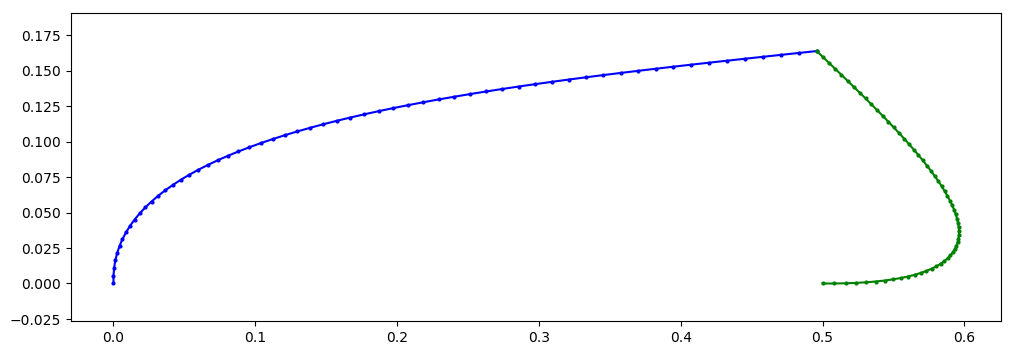

Optimal rendezvous location: [0.495833,0.163889]


In [10]:
X = getvalue(x)
println("Optimal rendezvous location: ",X[:Alice,:,60])
using PyPlot
figure(figsize=(12,4))
plot( X[:Alice,1,:][:], X[:Alice,2,:][:], "b.-", markersize=4 )
plot( X[:Bob,1,:][:], X[:Bob,2,:][:], "g.-", markersize=4 )
axis("equal");

__b) In addition to arriving at the same place at the same time, Alice and Bob should also make
sure their velocity vectors match when they rendezvous (otherwise, they might crash!) Solve the
rendezvous problem again with the additional velocity matching constraint and plot the resulting
trajectories. Is the optimal rendezvous location different from the one found in the first part?__

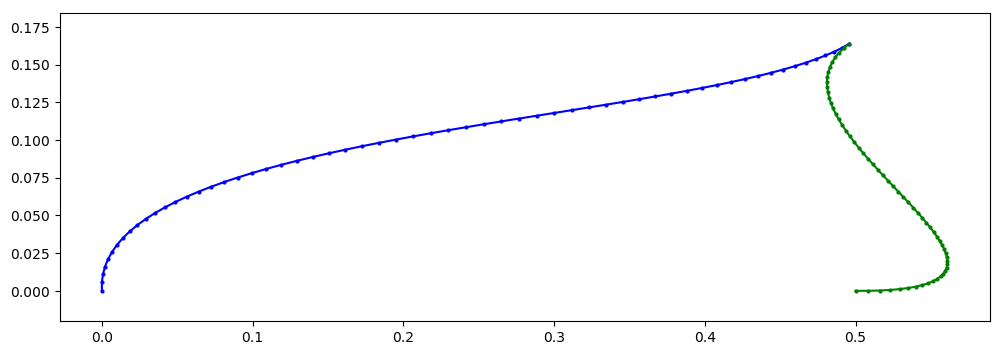

Optimal rendezvous location: [0.495833,0.163889]


In [11]:
@constraint(m, v[:Alice,:,T[2]] .== v[:Bob,:,T[2]])
solve(m)
X = getvalue(x)
println("Optimal rendezvous location: ",X[:Alice,:,60])
using PyPlot
figure(figsize=(12,4))
plot( X[:Alice,1,:][:], X[:Alice,2,:][:], "b.-", markersize=4 )
plot( X[:Bob,1,:][:], X[:Bob,2,:][:], "g.-", markersize=4 )
axis("equal");

__c) Alice and Bob forgot about one important detail. The hovercrafts each have a top speed of
35 mph. The solutions found in the previous parts are unacceptable because they require Alice to
exceed the maximum allowable speed. First, verify that this is indeed the case. Second, explain
how to alter your model to account for the speed limit. Finally, solve the rendezvous problem one
last time with all the constraints in place and verify that your solution respects the speed limit.__

In [12]:
V = getvalue(v)
[println("Max velocity for ",p ," : ",maximum(norm(V[p,:,t]) for t in 1:T[k])," mph") for p in person];

Max velocity for Alice : 42.79755747529796 mph
Max velocity for Bob : 30.0 mph


In [13]:
@constraint(m, maxspeed[t in 1:T[k], p in person], sum(v[p,:,t].^2) <= 35^2)
solve(m)
X = getvalue(x)
println("Optimal rendezvous location: ",X[:Alice,:,60])

Optimal rendezvous location: [0.41129,0.149452]


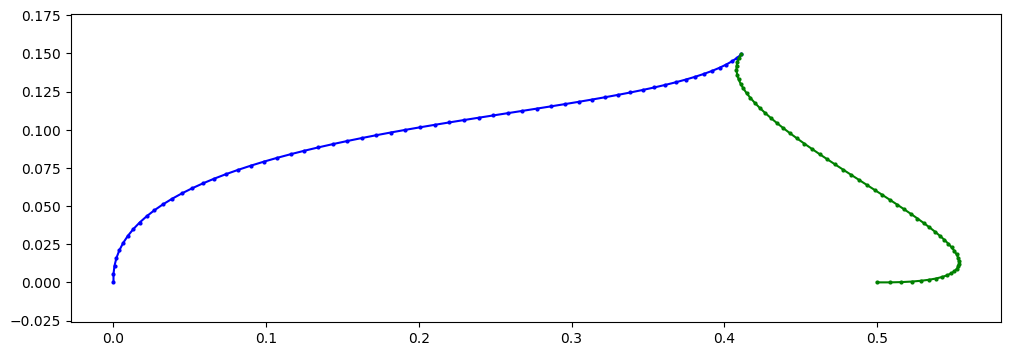

In [14]:
using PyPlot
figure(figsize=(12,4))
plot( X[:Alice,1,:][:], X[:Alice,2,:][:], "b.-", markersize=4 )
plot( X[:Bob,1,:][:], X[:Bob,2,:][:], "g.-", markersize=4 )
axis("equal");

In [15]:
V = getvalue(v)
[println("Max velocity for ",p ," : ",maximum(norm(V[p,:,t]) for t in 1:T[k])," mph") for p in person];

Max velocity for Alice : 34.99999964530002 mph
Max velocity for Bob : 30.0 mph
